In [1]:
%%time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = 12.0, 8.0

from pyts.transformation import GADF,GASF
from sklearn.preprocessing import normalize

import uproot

import keras
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Concatenate, Dense, Activation, Reshape, Conv1D , Conv2D, MaxPooling1D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization, Embedding, LSTM

Using TensorFlow backend.


CPU times: user 2.84 s, sys: 503 ms, total: 3.34 s
Wall time: 3.87 s


# Self-construct waveform

In [2]:
def standard(x,height,decay):
    y = height*np.exp(-x*decay)
    return y

def shifter(x,starts):
    L = int(starts*len(x))
    y = np.zeros(len(x))
    y[:L] = np.zeros(L) 
    y[L:] = x[:(len(x)-L)]
    return y

def comb_standard(x,second,height_1,decay_1,height_2,decay_2):
    L = int(second*len(x))
    y = np.zeros(len(x))
    y[:L] = standard(x[:L],height_1,decay_1)
    y[L:] = standard(x[:(len(x)-L)],height_2,decay_2)
    return y

def noiser(x,strength):
    y = x + np.random.normal(0,strength,len(x))
    return y

def noiser_long(x,strength):
    noise = np.random.normal(0,strength,len(x))
    y = x + np.cumsum(noise)*strength
    return y

def noiser_comb(x,sepfact,strength):
    L = int(sepfact*len(x))
    x[:L] = noiser(x[:L],strength)
    x[L:] = noiser_long(x[L:],strength)
    return x

def array_maker(entries):
    x = np.arange(0,1,1/4096)
    x = np.expand_dims(x,axis=0)
    x = np.tile(x,[entries,1])
    return x

def double(x,second,height_1,decay_1,height_2,decay_2,starts,sepfact=0.15,strength=0.02):
    y = comb_standard(x,second,height_1,decay_1,height_2,decay_2)
    y = shifter(y,starts)
    y = noiser_comb(y,sepfact,strength)
    return y

def single(x,height,decay,starts,sepfact=0.15,strength=0.02):
    y = standard(x,height,decay)
    y = shifter(y,starts)
    y = noiser_comb(y,sepfact,strength)
    return y

def event_creators_single(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(1,0.1)
        r = np.random.normal(5,1)
        s = np.random.normal(0.03,0.005)
        x[i] = single(x[i],w,r,s)
    return x

def event_creators_single_2(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(1,0.1)
        r = np.random.normal(10,2)
        s = np.random.normal(0.03,0.005)
        x[i] = single(x[i],w,r,s)
    return x

def event_creators_single_3(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(1,0.1)
        r = np.random.normal(4,1)
        s = np.random.normal(0.03,0.005)
        x[i] = single(x[i],w,r,s)
    return x

def event_creators_sharp(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(1,0.01)
        r = np.random.normal(100,20)
        s = np.random.normal(0.03,0.005)
        x[i] = single(x[i],w,r,s)    
    return x

def event_creators_double_equal(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(0.2,0.05)
        p = np.random.normal(1,0.01)
        q = np.random.normal(5,2)
        r = np.random.normal(1,0.01)
        s = np.random.normal(5,2)
        t = np.random.normal(0.03,0.005)
        x[i] = double(x[i],w,p,q,r,s,t)
    return x
    
def event_creators_double_unequal(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(0.2,0.05)
        p = np.random.normal(1,0.2)
        q = np.random.normal(50,10)
        r = np.random.normal(1,0.2)
        s = np.random.normal(50,10)
        t = np.random.normal(0.03,0.005)
        x[i] = double(x[i],w,p,q,r,s,t)
    return x

def event_creators_sharp_fat(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(0.015,0.001)
        p = np.random.normal(1,0.2)
        q = np.random.normal(100,20)
        r = np.random.normal(0.2,0.05)
        s = np.random.normal(5,2)
        t = np.random.normal(0.03,0.005)
        x[i] = double(x[i],w,p,q,r,s,t)
    return x

In [3]:
classes = 7
group = 5
training_ratio = 0.7
validation_ratio = 0.1
test_ratio = 0.2

def label(q,k):
    x = np.zeros(len(q))
    for i in range(len(q)):
        x[i] = k
    return x

def sep(q,k,z):
    y = label(q,k)
    x1, x2 ,x3 = np.split(q,[int(len(q)*training_ratio),int(len(q)*(training_ratio+validation_ratio))])
    y1, y2 ,y3 = np.split(y,[int(len(q)*training_ratio),int(len(q)*(training_ratio+validation_ratio))])
    if z == 0:
        return x1, y1
    if z == 1:
        return x2, y2
    if z == 2:
        return x3, y3
    
def comb(one,two,three,four,five,six,seven,portion):
    one1,one2 = sep(one,0,portion)
    two1,two2 = sep(two,1,portion)
    three1,three2 = sep(three,2,portion)
    four1,four2 = sep(four,3,portion)
    five1,five2 = sep(five,4,portion)
    six1,six2 = sep(six,5,portion)
    seven1,seven2 = sep(seven,6,portion)
    
    z = np.concatenate((one1,two1,three1,four1,five1,six1,seven1),axis=0)
    y = np.concatenate((one2,two2,three2,four2,five2,six2,seven2),axis=0)
    return z, y

def generator(x):
    while 1:
        beta = event_creators_single(1000)
        ls = event_creators_sharp(1000)
        dp_e = event_creators_double_equal(1000)
        dp_ue = event_creators_double_unequal(1000)
        lsbeta = event_creators_sharp_fat(1000)
        
        alpha = event_creators_single_2(1000)
        gamma = event_creators_single_3(1000)
        
        z1, z2 = comb(beta,ls,dp_e,dp_ue,lsbeta,alpha,gamma,x)
        s = np.random.permutation(np.arange(len(z2)))
        z1 = z1[s]
        z2 = z2[s]
#         print(len(z1))
        gasf = GASF(image_size=128, overlapping=False, scale='-1')
        
        for i in range(len(z2)):
            d1 = np.expand_dims(z1[i],axis=0)
            p = gasf.transform(d1)
            q = keras.utils.to_categorical(z2[i],classes)
            r = normalize(d1,norm="l1")
            yield [r,p],q

test = generator(0)
print(next(test)[0][0])
print(next(test)[0][0].shape)
# print(next(test)[0][1].shape)
print(next(test)[1].shape)

[[  4.87779015e-05   2.30020246e-05  -1.99807888e-05 ...,   9.44364216e-06
    8.88996724e-06   8.78460122e-06]]
(1, 4096)
(1, 7)


In [4]:
def multiple_inputs():
    feeder_1d = Input(shape=(4096,))
    model1 = Reshape((4096,1),input_shape=(4096,))(feeder_1d)
    model1 = Conv1D(64, kernel_size=16, strides=8,padding='same')(model1)
    model1 = MaxPooling1D(pool_size=2)(model1)
    model1 = Activation("relu")(model1)
    model1 = Conv1D(32, kernel_size=8, strides=8,padding='same')(model1)
    model1 = MaxPooling1D(pool_size=2)(model1)
    model1 = Activation("relu")(model1)
    model1 = Flatten()(model1)
    model1 = Dense(64,activation="relu")(model1)
    model1 = Dropout(0.2)(model1)
    model1 = Dense(64,activation="relu")(model1)
    model1 = Dropout(0.2)(model1)
    waveform_1d_out = Dense(7,activation="sigmoid")(model1)
    
    feeder_2d = Input(shape=(128,128))
    model2 = Reshape((128,128,1),input_shape=(128,128))(feeder_2d)
    model2 = Conv2D(64, kernel_size=(8,8),strides=4,padding='same')(model2)
    model2 = MaxPooling2D(pool_size=2)(model2)
    model2 = Activation("relu")(model2)
    model2 = Conv2D(32, kernel_size=(4,4),strides=4,padding='same')(model2)
    model2 = MaxPooling2D(pool_size=2)(model2)
    model2 = Activation("relu")(model2)
    model2 = Dropout(0.2)(model2)
    model2 = Flatten()(model2)
#     model2 = Dense(256,activation="relu")(model2)
#     model2 = Dropout(0.3)(model2)
    model2 = Dense(64,activation="relu")(model2)
    model2 = Dropout(0.3)(model2)
    model2 = Dense(64,activation="relu")(model2)
    model2 = Dropout(0.3)(model2)
    waveform_2d_out = Dense(7,activation="sigmoid")(model2)
    
#     feeder_para = Input(shape=(10,))
#     model3 = Dense(64,activation="relu")(feeder_para)
#     model3 = Dropout(0.2)(model3)
#     model3 = Dense(64,activation="relu")(model3)
#     model3 = Dropout(0.2)(model3)
# #     model3 = Dense(128,activation="relu")(model3)
# #     model3 = Dropout(0.2)(model3)
#     para_dense = Dense(7,activation="sigmoid")(model3)
    
    x = keras.layers.concatenate([waveform_1d_out, waveform_2d_out])
    x = Dense(256,activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(256,activation="relu")(x)
    x = Dropout(0.2)(x)
    main_output = Dense(7, activation='softmax', name='main_output')(x)
    
    model = Model(inputs=[feeder_1d,feeder_2d],outputs=[main_output])
    model.summary()
    
    return model

mult = multiple_inputs()
mult.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics=['accuracy'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 128, 128)      0                                            
____________________________________________________________________________________________________
input_1 (InputLayer)             (None, 4096)          0                                            
____________________________________________________________________________________________________
reshape_2 (Reshape)              (None, 128, 128, 1)   0           input_2[0][0]                    
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 4096, 1)       0           input_1[0][0]                    
___________________________________________________________________________________________

Epoch 1/5
4900/4900 [==============================] - 108s - loss: 0.2329 - acc: 0.8816 - val_loss: 0.2066 - val_acc: 0.8912
Epoch 2/5
4900/4900 [==============================] - 114s - loss: 0.2262 - acc: 0.8850 - val_loss: 0.2099 - val_acc: 0.8891
Epoch 3/5
4900/4900 [==============================] - 98s - loss: 0.2357 - acc: 0.8842 - val_loss: 0.2258 - val_acc: 0.8879
Epoch 4/5
4900/4900 [==============================] - 98s - loss: 0.2289 - acc: 0.8851 - val_loss: 0.2113 - val_acc: 0.8918
Epoch 5/5
4900/4900 [==============================] - 100s - loss: 0.2411 - acc: 0.8834 - val_loss: 0.2133 - val_acc: 0.8901
dict_keys(['loss', 'val_acc', 'val_loss', 'acc'])


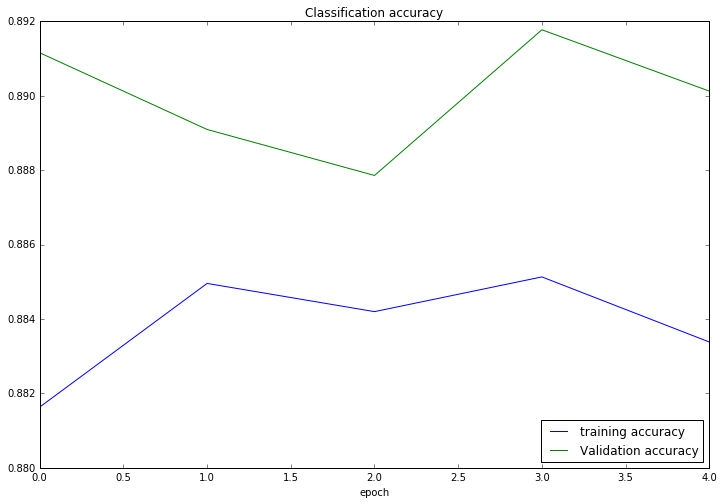

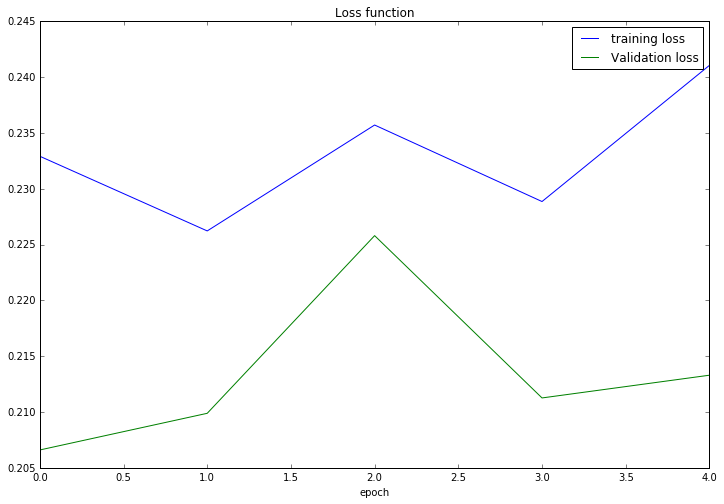

Classification accuracy = 0.890125753818
Test loss: 0.211857110393
Test accuracy: 0.890547734433


In [8]:
train_gen = generator(0)
val_gen = generator(1)
test_gen = generator(2)

steps_t = 4900
steps_vt = 693

history = mult.fit_generator(train_gen,steps_per_epoch=steps_t, epochs=5, verbose=1, validation_data=val_gen,validation_steps=steps_vt)
print(history.history.keys())
plt.figure()
plt.title("Classification accuracy")
plt.xlabel("epoch")
plt.plot(history.history['acc'],label="training accuracy")
plt.plot(history.history['val_acc'],label="Validation accuracy")
plt.legend(loc=4)
plt.show()

plt.figure()
plt.title("Loss function")
plt.xlabel("epoch")
plt.plot(history.history['loss'],label="training loss")
plt.plot(history.history['val_loss'],label="Validation loss")
plt.legend()
plt.show()

print("Classification accuracy =",history.history['val_acc'][-1])

# mult.save("GPU_CNN.h5")

score = mult.evaluate_generator(test_gen,steps=1531)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [9]:
mult.save("self_construct_beta_2dp_ls_lsbeta_gamma_alpha.h5")